In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,cohen_kappa_score, roc_curve, auc, roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

In [3]:
df = pd.read_csv('player_rpe.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_id    10499 non-null  object 
 1   user         10499 non-null  object 
 2   age          7069 non-null   float64
 3   height       7200 non-null   float64
 4   weight       8314 non-null   float64
 5   date         10499 non-null  float64
 6   duration     10499 non-null  int64  
 7   rpe          10363 non-null  float64
 8   team         10499 non-null  object 
 9   team_name    10499 non-null  object 
 10  sports_type  10499 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 902.4+ KB


# modeling

## use date, duration, rpe, sports_type to impute missing RPEs

In [5]:
df1 = df[['player_id', 'date', 'duration', 'rpe', 'sports_type', 'team']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   player_id    10499 non-null  object 
 1   date         10499 non-null  float64
 2   duration     10499 non-null  int64  
 3   rpe          10363 non-null  float64
 4   sports_type  10499 non-null  object 
 5   team         10499 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 492.3+ KB


In [6]:
df1

,player_id,date,duration,rpe,sports_type,team
0,5f059344239906121f93092d,1.593389e+09,65,5.0,Soccer,601bd6d892a0f655a0f12b24
1,5f059344239906121f93092d,1.593475e+09,45,5.0,Soccer,601bd6d892a0f655a0f12b24
2,5f059344239906121f93092d,1.593475e+09,60,6.0,Soccer,601bd6d892a0f655a0f12b24
3,5f059344239906121f93092d,1.593562e+09,80,6.0,Soccer,601bd6d892a0f655a0f12b24
4,5f059344239906121f93092d,1.593648e+09,45,5.0,Soccer,601bd6d892a0f655a0f12b24
...,...,...,...,...,...,...
10494,63359910236540b5949c8ef1,1.666025e+09,120,4.0,Volleyball,601bd6eb0bbb1f27e1b2696d
10495,6335992798b1146a62e46a96,1.665069e+09,210,6.0,Volleyball,601bd6eb0bbb1f27e1b2696d
10496,6335992798b1146a62e46a96,1.666111e+09,120,8.0,Volleyball,601bd6eb0bbb1f27e1b2696d
10497,633599e198b1146a62e46a97,1.666111e+09,120,2.0,Volleyball,601bd6eb0bbb1f27e1b2696d


In [7]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
    idx_list = []
 
    # traverse for all elements
    for i in range(len(list1)):
        # check if exists in unique_list or not
        if list1[i] not in unique_list:
            unique_list.append(list1[i])
            idx_list.append(i)
    return unique_list, idx_list

unique_list, idx_list = unique(df1['player_id'])
len(unique_list)

292

In [8]:
for i, val in enumerate(df1['date']):
    df1['date'][i] = datetime.utcfromtimestamp(val)

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/4062785338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'][i] = datetime.utcfromtimestamp(val)


In [9]:
df1['date'] = pd.to_datetime(df1['date'])

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/2129961175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = pd.to_datetime(df1['date'])


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   player_id    10499 non-null  object        
 1   date         10499 non-null  datetime64[ns]
 2   duration     10499 non-null  int64         
 3   rpe          10363 non-null  float64       
 4   sports_type  10499 non-null  object        
 5   team         10499 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 492.3+ KB


In [11]:
df1.sort_values(by = ['date'])

,player_id,date,duration,rpe,sports_type,team
0,5f059344239906121f93092d,2020-06-29 00:00:00,65,5.0,Soccer,601bd6d892a0f655a0f12b24
369,5f05939a239906121f930930,2020-06-29 00:00:00,65,6.0,Football,5f014886b8bec1cf08f7ca0e
3403,5f059378239906121f93092e,2020-06-29 00:00:00,65,6.0,Football,5f014886b8bec1cf08f7ca0e
3053,5f0592e2239906121f930929,2020-06-29 00:00:00,65,6.0,Football,5f014886b8bec1cf08f7ca0e
2640,5f0593d9c37cc79a7d6a6cae,2020-06-29 00:00:00,65,6.0,Football,5f014886b8bec1cf08f7ca0e
...,...,...,...,...,...,...
10459,63258f2e58c760bf189af1c4,2022-11-13 17:36:21,90,7.0,Rugby,601bd71e0bbb1f27e1b26971
10439,63258df15a6806ac4774cfb3,2022-11-13 18:55:03,90,7.0,Rugby,601bd71e0bbb1f27e1b26971
10474,632891338f74ce3fc560c1b4,2022-11-20 17:00:36,90,7.0,Rugby,601bd71e0bbb1f27e1b26971
10441,63258df15a6806ac4774cfb3,2022-11-21 13:10:04,90,8.0,Rugby,601bd71e0bbb1f27e1b26971


## encoding: player_id (integer), date (integer), team (onehot), ~~sports_type (onehot)~~

### player_id

In [12]:
ord_enc = OrdinalEncoder()
df1["player_id_encoded"] = ord_enc.fit_transform(df1[["player_id"]])
df1[["player_id", "player_id_encoded"]].tail(11)

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/1946122146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["player_id_encoded"] = ord_enc.fit_transform(df1[["player_id"]])


,player_id,player_id_encoded
10488,632bdd157f67b31d136e34c7,285.0
10489,632bdd157f67b31d136e34c7,285.0
10490,632bdd157f67b31d136e34c7,285.0
10491,632bdd157f67b31d136e34c7,285.0
10492,632bdd9ef7cfd4ae22ff81da,286.0
10493,633598f998b1146a62e46a95,287.0
10494,63359910236540b5949c8ef1,288.0
10495,6335992798b1146a62e46a96,289.0
10496,6335992798b1146a62e46a96,289.0
10497,633599e198b1146a62e46a97,290.0


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   player_id          10499 non-null  object        
 1   date               10499 non-null  datetime64[ns]
 2   duration           10499 non-null  int64         
 3   rpe                10363 non-null  float64       
 4   sports_type        10499 non-null  object        
 5   team               10499 non-null  object        
 6   player_id_encoded  10499 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 574.3+ KB


In [14]:
null_idx = df1[df1['rpe'].isnull()].index.tolist()
len(null_idx)

136

### date

In [15]:
def posix_time(dt):
    return ((dt - datetime(2020, 6, 29)) / timedelta(seconds=1))/(24*60*60)

df1['adjusted_date'] = df1['date'].apply(lambda x: posix_time(x))

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/1112159882.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['adjusted_date'] = df1['date'].apply(lambda x: posix_time(x))


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   player_id          10499 non-null  object        
 1   date               10499 non-null  datetime64[ns]
 2   duration           10499 non-null  int64         
 3   rpe                10363 non-null  float64       
 4   sports_type        10499 non-null  object        
 5   team               10499 non-null  object        
 6   player_id_encoded  10499 non-null  float64       
 7   adjusted_date      10499 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 656.3+ KB


In [17]:
df2 = df1[['player_id_encoded', 'adjusted_date', 'duration', 'rpe', 'sports_type', 'team']]

### team ~~sports type~~

In [18]:
df2["team_encoded"] = ord_enc.fit_transform(df2[["team"]])
df2[["team", "team_encoded"]].tail(11)

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/297005832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["team_encoded"] = ord_enc.fit_transform(df2[["team"]])


,team,team_encoded
10488,601bd68d92a0f655a0f12b22,3.0
10489,601bd68d92a0f655a0f12b22,3.0
10490,601bd68d92a0f655a0f12b22,3.0
10491,601bd68d92a0f655a0f12b22,3.0
10492,601bd68d92a0f655a0f12b22,3.0
10493,601bd6eb0bbb1f27e1b2696d,7.0
10494,601bd6eb0bbb1f27e1b2696d,7.0
10495,601bd6eb0bbb1f27e1b2696d,7.0
10496,601bd6eb0bbb1f27e1b2696d,7.0
10497,601bd6eb0bbb1f27e1b2696d,7.0


In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_id_encoded  10499 non-null  float64
 1   adjusted_date      10499 non-null  float64
 2   duration           10499 non-null  int64  
 3   rpe                10363 non-null  float64
 4   sports_type        10499 non-null  object 
 5   team               10499 non-null  object 
 6   team_encoded       10499 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 574.3+ KB


In [20]:
np.mean(df2.rpe)

6.300106146868667

In [21]:
df2 = df2[['player_id_encoded', 'adjusted_date', 'duration', 'rpe', 'team_encoded']]

In [22]:
'''
ohe = make_column_transformer(
    (OneHotEncoder(), ['sports_type']),
    remainder='passthrough')

ohe_transformed = ohe.fit_transform(df2)
ohe_df2 = pd.DataFrame(
    ohe_transformed, 
    columns=ohe.get_feature_names_out()
)



print(ohe_df2.info())


ohe_df2
'''

"\nohe = make_column_transformer(\n    (OneHotEncoder(), ['sports_type']),\n    remainder='passthrough')\n\nohe_transformed = ohe.fit_transform(df2)\nohe_df2 = pd.DataFrame(\n    ohe_transformed, \n    columns=ohe.get_feature_names_out()\n)\n\n\n\nprint(ohe_df2.info())\n\n\nohe_df2\n"

## split training and testing data set

In [42]:
data = df2#ohe_df2
not_null_attr = data.isnull().sum()[data.isnull().sum()==0].index.tolist()
null_attr = data.isnull().sum()[data.isnull().sum() != 0].index.tolist()
testing = data[data['rpe'].isnull()]
training = data[~data['rpe'].isnull()]
training_x = training[not_null_attr].drop(['player_id_encoded'], axis=1)
training_y = training[null_attr]
#attrbs = {}
#njobs = 100

In [43]:
X_training,X_validation,y_training,y_validation = train_test_split(
    training_x,training_y,test_size=0.2,random_state=42)

print(X_training.shape,X_validation.shape, y_training.shape,y_validation.shape)
#print(X_training_chronic.shape,X_validation_chronic.shape,y_training_chronic.shape,y_validation_chronic.shape)

(8290, 3) (2073, 3) (8290, 1) (2073, 1)


In [49]:
y_training

,rpe
5246,8.0
2141,10.0
1785,7.0
1094,5.0
3901,7.0
...,...
5859,6.0
5314,7.0
5515,1.0
890,6.0


In [50]:
y_validation

,rpe
5086,4.0
8458,7.0
6128,7.0
1231,7.0
3541,7.0
...,...
10290,6.0
6643,7.0
7813,7.0
1886,3.0


In [ ]:
def mean_median_mode_foundation(X_training,X_validation,y_training,y_validation, kind = 'mean'):
    if kind == 'mean':
        pred_found = np.mean(y_training.dropna())
        return pred_found
    elif kind == 'median':
        pred_found = np.median(y_training.dropna())
        return pred_found
    elif kind == 'mode':
        pred_found = mode(y_training.dropna())
        return pred_found

def miss_forest_impute1(X_training,X_validation,y_training,y_validation, attr):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_training,y_training)
        
    y_pred = model.predict(X_validation)
    
    return y_pred

In [39]:
df[i] = mean_median_mode_imputation(df[i], kind = 'median')
    
for job in range(njobs):
    value, idx = miss_forest_impute(df, i)
    df[i].iloc[idx] = value
    
attrbs[i] = df[i]

pred = reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
r2 = r2_score(y_validation, pred)
print('RF,RMSE:',rmse, 'RF,R2:', r2)

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/2333692571.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(X_training, y_training)


RFRMSE: 1.495656497658273 0.3935468189347293


In [40]:
rf_model = RandomForestRegressor(
         max_depth= None,
         min_samples_leaf= 1,
         min_samples_split= 2,
         n_estimators= 5000,
         random_state=42)



pred_chronic_rf, rmse_chronic_rf = eval_pred_truth(rf_model_chr, X_training_chronic,y_training_chronic,X_validation_chronic, y_validation_chronic)
pred_chronic_rf_sc, rmse_chronic_rf_sc = eval_pred_truth(rf_model_chr, X_train_scaled_chronic,y_training_chronic,X_validation_scaled_chronic, y_validation_chronic)
print("scaled predictors, RF RMSE: ", rmse_chronic_rf_sc)
print("unscaled predictors, RF RMSE: ", rmse_chronic_rf)

y_pred_rf_chr = pred_chronic_rf.tolist()
plot_pred_truth(y_truth_chr, y_pred_rf_chr)

NameError: name 'eval_pred_truth' is not defined

## missing forest imputation

In [23]:
from statistics import mode
def add_label(data, attr, name_notnan = 'Training', name_nan = 'Predict'):
    null_pos = data[attr][data[attr].isnull()].index
    data['Label'] = name_notnan
    data['Label'].iloc[null_pos] = name_nan

def mean_median_mode_imputation(data, kind = 'mode'):
    if kind == 'mean':
        return data.fillna(np.mean(data.dropna()))
    elif kind == 'median':
        return data.fillna(np.median(data.dropna()))
    elif kind == 'mode':
        return data.fillna(mode(data))

def miss_forest_impute(data, attr):
    train_data, test_data = data[data['Label'] == 'Training'], data[data['Label'] == 'Predict']
    
    y = data[attr]
    x = data.drop(['Label', attr], axis = 1)
    
    y_train = train_data[attr]
    x_train = train_data.drop(['Label', attr], axis = 1)
    
    y_test = test_data[attr]
    x_test = test_data.drop(['Label', attr], axis = 1)
    
    
    model = RandomForestRegressor()
    model.fit(x,y)
        
    y_pred = model.predict(x_test)
    
    return y_pred, y[data['Label'] == 'Predict'].index

In [24]:
data = df2#ohe_df2
not_null_attr = data.isnull().sum()[data.isnull().sum()==0].index
null_attr = data.isnull().sum()[data.isnull().sum() != 0].index
attrbs = {}
njobs = 100

for i in null_attr:
    df = pd.concat((data[not_null_attr], data[i]), axis = 1)
    add_label(df, i)
    df[i] = mean_median_mode_imputation(df[i], kind = 'median')
    
    for job in range(njobs):
        value, idx = miss_forest_impute(df, i)
        df[i].iloc[idx] = value
    
    attrbs[i] = df[i]

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/2459939149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'].iloc[null_pos] = name_nan
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].i

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].i

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value
/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].i

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3166261018.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].iloc[idx] = value


In [25]:
imputed = pd.DataFrame.from_dict(attrbs)
df2_imputed = pd.concat((data[not_null_attr], imputed), axis = 1)
#player_info = pd.concat((player_info['player_id'], player_info_1), axis = 1)
df2_imputed

,player_id_encoded,adjusted_date,duration,team_encoded,rpe
0,4.0,0.000000,65,5.0,5.0
1,4.0,1.000000,45,5.0,5.0
2,4.0,1.000000,60,5.0,6.0
3,4.0,2.000000,80,5.0,6.0
4,4.0,3.000000,45,5.0,5.0
...,...,...,...,...,...
10494,288.0,840.693785,120,7.0,4.0
10495,289.0,829.630104,210,7.0,6.0
10496,289.0,841.695023,120,7.0,8.0
10497,290.0,841.697234,120,7.0,2.0


In [26]:
print(len(df1[df1.index.isin(null_idx)]))
df1[df1.index.isin(null_idx)]

136


,player_id,date,duration,rpe,sports_type,team,player_id_encoded,adjusted_date
69,5f0592cc239906121f930928,2020-08-24 11:53:13,8,NaN,Football,5f014886b8bec1cf08f7ca0e,1.0,56.495289
70,5f0592cc239906121f930928,2020-08-25 05:42:16,8,NaN,Football,5f014886b8bec1cf08f7ca0e,1.0,57.237685
71,5f0592cc239906121f930928,2020-08-27 03:28:22,7,NaN,Football,5f014886b8bec1cf08f7ca0e,1.0,59.144699
72,5f0592cc239906121f930928,2020-08-28 03:19:50,8,NaN,Football,5f014886b8bec1cf08f7ca0e,1.0,60.138773
73,5f0592cc239906121f930928,2020-08-29 12:11:08,5,NaN,Football,5f014886b8bec1cf08f7ca0e,1.0,61.507731
...,...,...,...,...,...,...,...,...
9557,6138a297afb8a12aedcf2da0,2022-05-12 12:48:11,8,NaN,Basketball,601bd5188223a65cf051ce53,222.0,682.533461
9569,6138a2ad911ce14a6dee0227,2022-05-12 12:48:11,6,NaN,Basketball,601bd5188223a65cf051ce53,223.0,682.533461
10000,61715988edb67a29a8203e20,2022-05-12 12:48:11,7,NaN,Basketball,601bd5188223a65cf051ce53,254.0,682.533461
10008,617159f8edb67a29a8203e21,2022-05-12 12:48:11,7,NaN,Basketball,601bd5188223a65cf051ce53,255.0,682.533461


In [27]:
df2_imputation=df2_imputed[df2_imputed.index.isin(null_idx)]

In [28]:
print(len(df2_imputation))
df2_imputation

136


,player_id_encoded,adjusted_date,duration,team_encoded,rpe
69,1.0,56.495289,8,0.0,6.013946
70,1.0,57.237685,8,0.0,6.011329
71,1.0,59.144699,7,0.0,6.009033
72,1.0,60.138773,8,0.0,6.009013
73,1.0,61.507731,5,0.0,6.010318
...,...,...,...,...,...
9557,222.0,682.533461,8,2.0,5.246875
9569,223.0,682.533461,6,2.0,4.880919
10000,254.0,682.533461,7,2.0,5.287282
10008,255.0,682.533461,7,2.0,5.287282


In [29]:
df2_imputation['RPE'] = df2_imputation['rpe'].round(0)

/var/folders/hs/hd11mm8x1qs3vhmmryb7kq380000gn/T/ipykernel_1364/3171804748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_imputation['RPE'] = df2_imputation['rpe'].round(0)


In [30]:
df2_imputation

,player_id_encoded,adjusted_date,duration,team_encoded,rpe,RPE
69,1.0,56.495289,8,0.0,6.013946,6.0
70,1.0,57.237685,8,0.0,6.011329,6.0
71,1.0,59.144699,7,0.0,6.009033,6.0
72,1.0,60.138773,8,0.0,6.009013,6.0
73,1.0,61.507731,5,0.0,6.010318,6.0
...,...,...,...,...,...,...
9557,222.0,682.533461,8,2.0,5.246875,5.0
9569,223.0,682.533461,6,2.0,4.880919,5.0
10000,254.0,682.533461,7,2.0,5.287282,5.0
10008,255.0,682.533461,7,2.0,5.287282,5.0


In [31]:
rpes = df2_imputation['RPE'].unique().tolist()
counts = []
for rpe in rpes:
    counts.append((df2_imputation.RPE == rpe).sum())

Text(0, 0.5, 'counts')

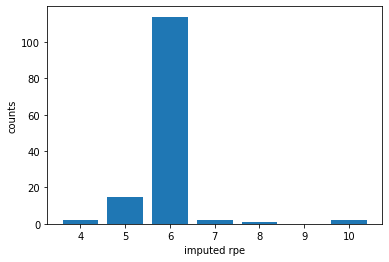

In [32]:
plt.bar(rpes, counts)
plt.xlabel('imputed rpe')
plt.ylabel('counts')

In [33]:
df2

,player_id_encoded,adjusted_date,duration,rpe,team_encoded
0,4.0,0.000000,65,5.0,5.0
1,4.0,1.000000,45,5.0,5.0
2,4.0,1.000000,60,6.0,5.0
3,4.0,2.000000,80,6.0,5.0
4,4.0,3.000000,45,5.0,5.0
...,...,...,...,...,...
10494,288.0,840.693785,120,4.0,7.0
10495,289.0,829.630104,210,6.0,7.0
10496,289.0,841.695023,120,8.0,7.0
10497,290.0,841.697234,120,2.0,7.0


In [34]:
rpes_ori = df2['RPE'].unique().tolist()
counts_ori = []
for rpe in rpes_ori:
    counts_ori.append((df2.RPE == rpe).sum())
    
    
plt.bar(rpes_ori, counts_ori)
plt.xlabel('rpe')
plt.ylabel('counts')

KeyError: 'RPE'

In [ ]:
for i in range(len(null_idx)):
    df1['rpe'][null_idx[i]] = df2_imputed['rpe'][null_idx[i]]

In [ ]:
df1[df1.index.isin(null_idx)]

In [ ]:
plt.plot(df1[df1.index.isin(null_idx)]['player_id'],df1[df1.index.isin(null_idx)]['rpe'])
plt.xlabel('player')
plt.ylabel('rpe')

In [ ]:
df_team_kcs = df1[df1['team'] == '5f014886b8bec1cf08f7ca0e']
df_team_kcs

In [ ]:
df_team_kcs['adjusted_date'] = df_team_kcs['adjusted_date'].astype(int)

In [ ]:
df_team_kcs.info()

In [ ]:
plt.scatter('duration', 'rpe', data = df_team_kcs)
plt.xlabel('duration')
plt.ylabel('rpe')
plt.show()

# regression 

## random forest

In [ ]:
#base rf regression
reg = RandomForestRegressor(random_state=42)
reg.fit(X_training, y_training)

pred = reg.predict(X_validation)
rmse = np.sqrt(mean_squared_error(y_validation, pred))
r2 = r2_score(y_validation, pred)
print('RFRMSE:',rmse, r2)

In [ ]:
rf_model = RandomForestRegressor(
         max_depth= None,
         min_samples_leaf= 1,
         min_samples_split= 2,
         n_estimators= 5000,
         random_state=42)



pred_chronic_rf, rmse_chronic_rf = eval_pred_truth(rf_model_chr, X_training_chronic,y_training_chronic,X_validation_chronic, y_validation_chronic)
pred_chronic_rf_sc, rmse_chronic_rf_sc = eval_pred_truth(rf_model_chr, X_train_scaled_chronic,y_training_chronic,X_validation_scaled_chronic, y_validation_chronic)
print("scaled predictors, RF RMSE: ", rmse_chronic_rf_sc)
print("unscaled predictors, RF RMSE: ", rmse_chronic_rf)

y_pred_rf_chr = pred_chronic_rf.tolist()
plot_pred_truth(y_truth_chr, y_pred_rf_chr)